In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
%matplotlib inline

from albumentations import PadIfNeeded, Compose, Rotate
from torch.utils.data import Dataset, DataLoader
from model import DFNet, InpaintWrapper
from dataset import InpaintingDataset
from utils import ToTensor,to_numpy,FixedRotate

img_dir = Path('/storage/monty/huawei_inpainting/DATASET_INPAINTING/test/')
checkpoint_path = '/storage/monty/huawei_inpainting/model_places2.pth'
device = 'cuda'

model = DFNet().to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

model = InpaintWrapper(model)

In [2]:
from tqdm import tqdm_notebook
from albumentations import CenterCrop

augs, reverse_augs = [], []
angles = [0] +[30,45,60,90] + [-30,-45,-60,-90]
for a in angles:
    augs.append([FixedRotate(a)])
    reverse_augs.append([FixedRotate(-a)])

In [3]:
all_results = []
for aug, reverse_aug in zip(augs, reverse_augs):
    transform = Compose([PadIfNeeded(min_height=1024, min_width=1024)] + aug + [ToTensor()])
    reverse_transform =  Compose(reverse_aug+ [CenterCrop(600,500)])
    
    dataset = InpaintingDataset(img_dir, img_dir/'test_mask.txt', train=False, transform=transform, expand_mask=3)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    results = []
    for batch in tqdm_notebook(loader):
        imgs, masks = batch
        inpainted = model(imgs.to(device), masks.to(device))
        inpainted = to_numpy(inpainted)[0]
        results.append(reverse_transform(image=inpainted)['image'])
    all_results.append(results)

In [4]:
#blend images
all_results = np.array(all_results)
all_results = all_results.mean(axis=0).astype('uint8')

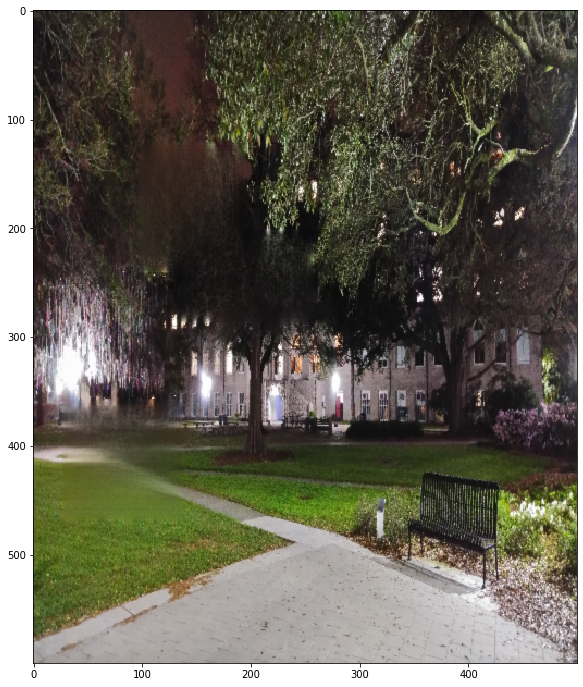

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(all_results[20])

In [6]:
# Reconstruct non-mask areas
dataset = InpaintingDataset(img_dir, img_dir/'test_mask.txt', train=False)

results = []
for inpainted, (orig, mask) in zip(all_results, dataset):
    mask =  np.stack([mask>0]*3, axis=-1).astype(float)
    inpainted = orig * mask + inpainted * (1-mask)
    results.append(inpainted.astype('uint8'))

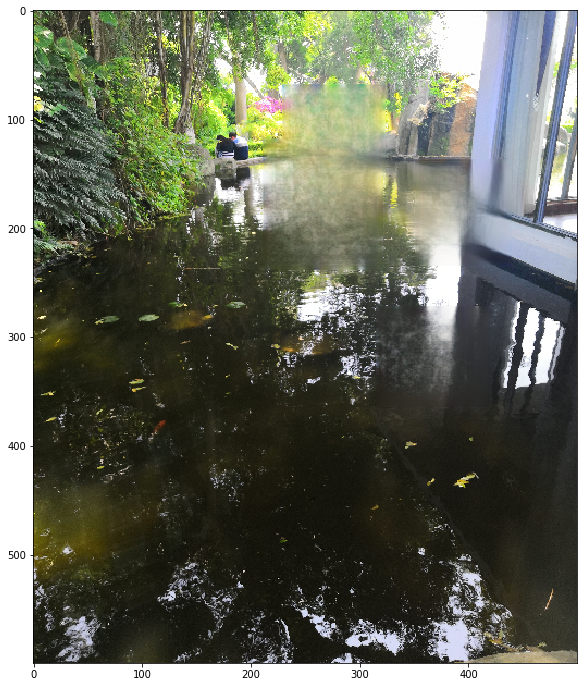

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(results[11]) 

In [106]:
from skimage.io import imsave
import os
# os.mkdir('result')

for name, img in tqdm_notebook(zip(dataset.imgs, results), total=len(results)):
    imsave('result/'+name+'.png', img)

In [107]:
!rm result.zip
!zip -j -r -D result.zip result

  adding: 821.png (deflated 0%)
  adding: 832.png (deflated 0%)
  adding: 841.png (deflated 0%)
  adding: 813.png (deflated 0%)
  adding: 828.png (deflated 0%)
  adding: 836.png (deflated 0%)
  adding: 840.png (deflated 0%)
  adding: 827.png (deflated 0%)
  adding: 818.png (deflated 0%)
  adding: 807.png (deflated 0%)
  adding: 849.png (deflated 0%)
  adding: 806.png (deflated 0%)
  adding: 815.png (deflated 1%)
  adding: 830.png (deflated 0%)
  adding: 800.png (deflated 0%)
  adding: 837.png (deflated 0%)
  adding: 822.png (deflated 0%)
  adding: 824.png (deflated 0%)
  adding: 823.png (deflated 0%)
  adding: 834.png (deflated 0%)
  adding: 845.png (deflated 0%)
  adding: 831.png (deflated 0%)
  adding: 833.png (deflated 0%)
  adding: 846.png (deflated 0%)
  adding: 812.png (deflated 0%)
  adding: 803.png (deflated 0%)
  adding: 826.png (deflated 0%)
  adding: 829.png (deflated 0%)
  adding: 843.png (deflated 0%)
  adding: 802.png (deflated 0%)
  adding: 847.png (deflated 0%)
  adding